In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

import matplotlib.pyplot as plt
import torch

from caustic.constants import arcsec_to_rad, rad_to_arcsec
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import NFW, Point, SIS, SIE, MultiplaneLens
from caustic.sources import Sersic
from caustic.utils import get_meshgrid


device = "cpu"
cosmology = FlatLambdaCDMCosmology()
res = 0.05
nx = 100
ny = 100
thx, thy = get_meshgrid(res, nx, ny)

# Source for testing
sersic = Sersic(
    0.05, 0.01, 0, 1.0, 5.0, 1.0, 1.0, z_ref=None, cosmology=cosmology, device=device
)

In [3]:
from astropy.cosmology import FlatLambdaCDM
import lenstronomy
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
import numpy as np


thx_ls = thx.numpy()
thy_ls = thy.numpy()
shared_cosmo_ls = FlatLambdaCDM(H0=cosmology.h0 * 100, Om0=cosmology.Om0, Ob0=0.0)

## NFW
This differs by more than 1% from lenstronomy.

In [4]:
z_l = torch.tensor(1.0, device=device)
z_s = torch.tensor(2.5, device=device)
thx0 = 0
thy0 = 0
m = 1e13  # solMass
c = 15
nfw = NFW(thx0, thy0, m, c, cosmology=cosmology, device=device)

img = sersic.brightness(*nfw.raytrace(thx, thy, z_l, z_s))

In [5]:
cosmology_ls = LensCosmo(
    z_lens=z_l.numpy(), z_source=z_s.numpy(), cosmo=shared_cosmo_ls
)
Rs_angle, alpha_Rs = cosmology_ls.nfw_physical2angle(M=m, c=c)
model = LensModel(
    lens_model_list=["NFW"], z_source=z_s.numpy(), lens_redshift_list=z_l.numpy()
)
kwargs_nfw = {"center_x": thx0, "center_y": thy0, "Rs": Rs_angle, "alpha_Rs": alpha_Rs}

thx_src_ls, thy_src_ls = model.ray_shooting(thx_ls, thy_ls, kwargs=[kwargs_nfw])
img_ls = sersic.brightness(torch.from_numpy(thx_src_ls), torch.from_numpy(thy_src_ls))

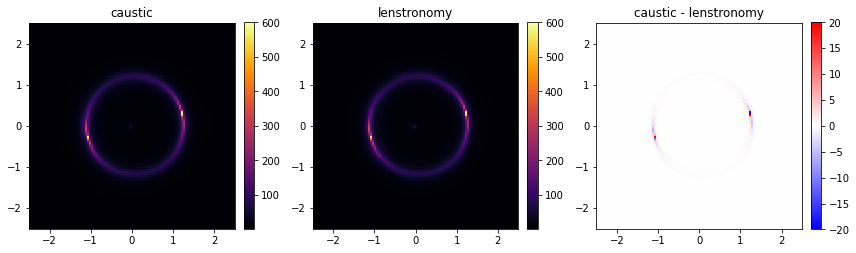

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(thx, thy, img, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic")

plt.subplot(1, 3, 2)
plt.pcolormesh(thx, thy, img_ls, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("lenstronomy")

plt.subplot(1, 3, 3)
plt.pcolormesh(thx, thy, img - img_ls, vmin=-20, vmax=20, cmap="bwr")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic - lenstronomy")

plt.tight_layout()

## SIS

In [7]:
z_l = torch.tensor(1.0, device=device)
z_s = torch.tensor(2.5, device=device)
thx0 = 0
thy0 = 0
sigma_v = 350  # km/s
sis = SIS(thx0, thy0, sigma_v, cosmology=cosmology, device=device)

img = sersic.brightness(*sis.raytrace(thx, thy, z_l, z_s))

In [8]:
model = LensModel(
    lens_model_list=["SIS"], z_source=z_s.numpy(), lens_redshift_list=[z_l.numpy()]
)
kwargs_sis = {"center_x": thx0, "center_y": thy0, "theta_E": sis.th_ein(z_l, z_s).item()}

thx_src_ls, thy_src_ls = model.ray_shooting(thx_ls, thy_ls, kwargs=[kwargs_sis])
img_ls = sersic.brightness(torch.from_numpy(thx_src_ls), torch.from_numpy(thy_src_ls))

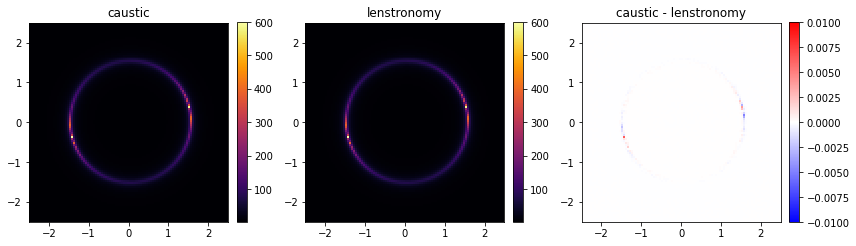

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(thx, thy, img, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic")

plt.subplot(1, 3, 2)
plt.pcolormesh(thx, thy, img_ls, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("lenstronomy")

plt.subplot(1, 3, 3)
plt.pcolormesh(thx, thy, img - img_ls, vmin=-0.01, vmax=0.01, cmap="bwr")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic - lenstronomy")

plt.tight_layout()

## SIE

In [10]:
z_l = torch.tensor(1.0, device=device)
z_s = torch.tensor(2.5, device=device)
thx0 = 0
thy0 = 0
th_ein = 1.5  # arcsec
q = 0.8
phi = pi / 3
sie = SIE(
    thx0,
    thy0,
    th_ein,
    q,
    phi,
    z_l_ref=z_l,
    z_s_ref=z_s,
    cosmology=cosmology,
    device=device,
)

img = sersic.brightness(*sie.raytrace(thx, thy, z_l, z_s))

In [11]:
model = LensModel(lens_model_list=["SIE"], z_source=z_s.numpy(), lens_redshift_list=[z_l.numpy()])
e1, e2 = param_util.phi_q2_ellipticity(phi, q)
kwargs_sie = {
    "center_x": thx0,
    "center_y": thy0,
    "theta_E": th_ein,
    "e1": e1,
    "e2": e2,
}

thx_src_ls, thy_src_ls = model.ray_shooting(thx_ls, thy_ls, kwargs=[kwargs_sie])
img_ls = sersic.brightness(torch.from_numpy(thx_src_ls), torch.from_numpy(thy_src_ls))

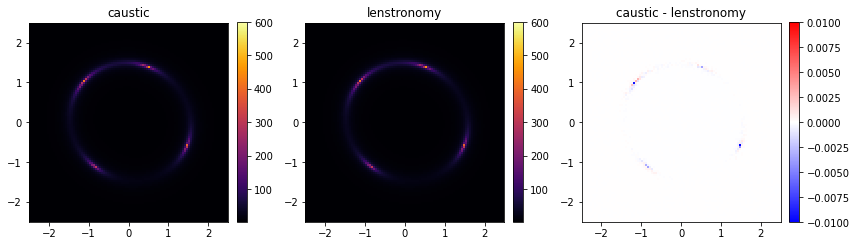

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(thx, thy, img, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic")

plt.subplot(1, 3, 2)
plt.pcolormesh(thx, thy, img_ls, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("lenstronomy")

plt.subplot(1, 3, 3)
plt.pcolormesh(thx, thy, img - img_ls, vmin=-0.01, vmax=0.01, cmap="bwr")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic - lenstronomy")

plt.tight_layout()

## Multiplane

### Validate with lenses in single plane

In [13]:
thx0 = 0
thy0 = 0
c = 15
nfw_1 = NFW(0.01, -0.02, 8e12, c, cosmology=cosmology, device=device)
nfw_2 = NFW(1.0, 0.6, 2e11, c, cosmology=cosmology, device=device)
z_ls = torch.tensor([0.8, 0.8], device=device)
multiplane_lens = MultiplaneLens([nfw_1, nfw_2], z_ls, cosmology, device)
z_s = torch.tensor(2.5)

img = sersic.brightness(*multiplane_lens.raytrace(thx, thy, z_ss=z_s))

ax_1, ay_1 = nfw_1.alpha(thx, thy, z_ls[0], z_s)
ax_2, ay_2 = nfw_2.alpha(thx, thy, z_ls[1], z_s)
img_ref = sersic.brightness(thx - (ax_1 + ax_2), thy - (ay_1 + ay_2))

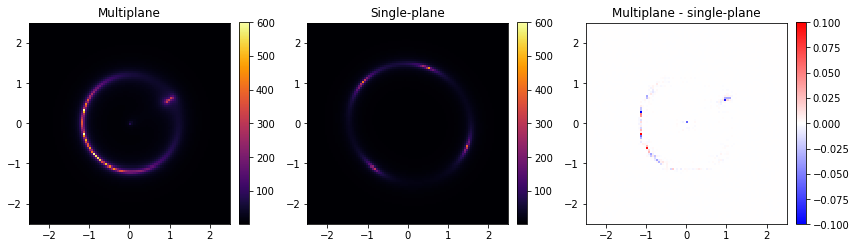

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(thx, thy, img, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Multiplane")

plt.subplot(1, 3, 2)
plt.pcolormesh(thx, thy, img_ls, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Single-plane")

plt.subplot(1, 3, 3)
plt.pcolormesh(thx, thy, img - img_ref, vmin=-0.1, vmax=0.1, cmap="bwr")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Multiplane - single-plane")

plt.tight_layout()

### Compare with lenstronomy

In [15]:
c = 15
thx0_1 = 0.01
thy0_1 = -0.02
m_1 = 8e12
thx0_2 = 1.0
thy0_2 = 0.5
m_2 = 2e11
nfw_1 = NFW(thx0_1, thy0_1, m_1, c, cosmology=cosmology, device=device)
nfw_2 = NFW(thx0_2, thy0_2, m_2, c, cosmology=cosmology, device=device)
z_ls = torch.tensor([0.8, 1.2], device=device)
multiplane_lens = MultiplaneLens([nfw_1, nfw_2], z_ls, cosmology, device)
z_s = torch.tensor(2.5)

img = sersic.brightness(*multiplane_lens.raytrace(thx, thy, z_ss=z_s))

In [16]:
model = LensModel(
    lens_model_list=["NFW", "NFW"],
    z_source=z_s.numpy(),
    lens_redshift_list=list(z_ls.numpy()),
    cosmo=shared_cosmo_ls,
    multi_plane=True
)

cosmology_ls = LensCosmo(
    z_lens=z_ls[0].numpy(), z_source=z_s.numpy(), cosmo=shared_cosmo_ls
)
Rs_angle_1, alpha_Rs_1 = cosmology_ls.nfw_physical2angle(M=m_1, c=c)
kwargs_nfw_1 = {
    "center_x": thx0_1,
    "center_y": thy0_1,
    "Rs": Rs_angle_1,
    "alpha_Rs": alpha_Rs_1,
}

cosmology_ls = LensCosmo(
    z_lens=z_ls[1].numpy(), z_source=z_s.numpy(), cosmo=shared_cosmo_ls
)
Rs_angle_2, alpha_Rs_2 = cosmology_ls.nfw_physical2angle(M=m_2, c=c)
kwargs_nfw_2 = {
    "center_x": thx0_2,
    "center_y": thy0_2,
    "Rs": Rs_angle_2,
    "alpha_Rs": alpha_Rs_2,
}

thx_src_ls, thy_src_ls = model.ray_shooting(
    thx_ls, thy_ls, kwargs=[kwargs_nfw_1, kwargs_nfw_2]
)
img_ls = sersic.brightness(torch.from_numpy(thx_src_ls), torch.from_numpy(thy_src_ls))

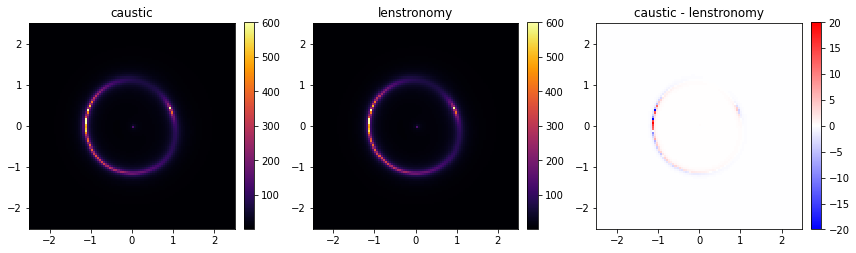

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(thx, thy, img, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic")

plt.subplot(1, 3, 2)
plt.pcolormesh(thx, thy, img_ls, vmax=600, cmap="inferno")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("lenstronomy")

plt.subplot(1, 3, 3)
plt.pcolormesh(thx, thy, img - img_ls, vmin=-20, vmax=20, cmap="bwr")
plt.gca().set_aspect("equal")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("caustic - lenstronomy")

plt.tight_layout()

## Using data as source galaxy

In [4]:
from caustic.sources.probes import PROBESDataset
from caustic.sources.imagesource import ImageSource

In [5]:
probes_ds = PROBESDataset("/Users/amcoogan/Work/Lensing/data/probes.h5", 0)

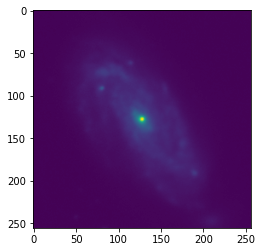

In [6]:
plt.imshow(probes_ds[13][0])

In [89]:
z_l = torch.tensor(1.0, device=device)
z_s = torch.tensor(2.5, device=device)

images = probes_ds[13:29]
img_src = ImageSource(images)

thx0 = torch.tensor(0.0, device=device)
thy0 = torch.tensor(0.0, device=device)
th_ein = torch.tensor(1.5, device=device)  # arcsec
q = torch.tensor(0.8, device=device)
phi = torch.tensor(pi / 3, device=device)
sie = SIE(
    thx0,
    thy0,
    th_ein,
    q,
    phi,
    z_l_ref=z_l,
    z_s_ref=z_s,
    cosmology=cosmology,
    device=device,
)

bx, by = sie.raytrace(thx, thy, z_l, z_s)
img = img_src.brightness(bx, by)

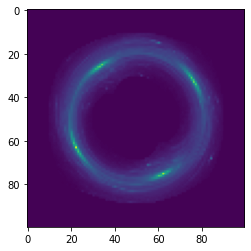

In [90]:
plt.imshow(img[6, 0])

# User stories

Alex wants to simulate a ton of lensing systems with deflection fields and sources drawn from Illustris to train a RIM. He does not care about including perturbers for now -- he just wants to generate 1,000,000 mock observations.
* Precompute deflection fields from kappa maps
* Wrappers to interpolate sources and deflection fields
* Batchable over sources and lenses

He also wants to generate observations using analytic deflection fields and PROBES images.

In [ ]:
class Simulator:
    def __init__(self, thx, thy, lens_dl, source_dl, z_l, z_s, cosmology):
        ...

    def __iter__(self):
        return self
    
    def __next__(self):
        for lens_batch, source_batch in zip(self.lens_dl, self.source_dl):
            # Return batches of lensed images...
            bx, by = lens.raytrace(self.thx, self.thy, self.z_l, self.z_s)
            yield source.brightness(bx, by)

        # ...until the dataloaders are exhausted
        raise StopIteration

Charles has implemented an ML model to speed up multiplane lensing. It consists of a model for the foreground LOS halos and a `Background` model that takes in rays deflected by a lens galaxy and traces them further. Charles wants to simulate images with sources injected at various redshifts.
* Fast sampler for the redshifts, positions and masses of the LOS halos
* This is batchable across systems when the systems have the same number of foreground and background halos

In [ ]:
class MLMultiplaneLens:
    def raytrace(self, thx, thy, params_fg, params_bg, params_md, md)
        # Trace through fg structure to get coordinates and angles of rays
        thx, thy, bx, by = self.fg_model(thx, thy, params_md.z)

        # Sum physical deflection angle from main lens
        ahx, ahy = self.main_lens.alpha_hat(thx, thy, z_l)
        bx += ahx
        by += ahy

        # Trace to source redshift
        thx, thy = self.bg_model(thx, thy, bx, by)


class Simulator:
    def __init__(
        self, thx, thy, fg_model, main_lens, z_l, bg_model, source_dl, z_s, cosmology
    ):
        ...

    def __iter__(self):
        return self
    
    def __next__(self):
        for source in self.source_dl:
            # Sample some perturbers
            params_fg = self.sample_params_fg()
            params_bg = self.sample_params_bg()

            # Trace through fg structure to get coordinates and angles of
            # rays
            thx, thy, bx, by = self.fg_model(self.thx, self.thy, self.z_l)

            # Sum physical deflection angle from main lens
            ahx, ahy = self.main_lens.alpha_hat(thx, thy, z_l)
            bx += ahx
            by += ahy

            # Trace to source redshift
            thx, thy = self.bg_model(thx, thy, bx, by)

            yield source.brightness(thx, thy)
        
        # We've looped through all the sources
        raise StopIteration

Adam wants to simulate multiplane lensing using the recursive lensing equation, with sources injected at various redshifts.
* This is not batchable between systems or across halos within a system

He also wants to test out the [dominant lens approximation](https://arxiv.org/pdf/2104.08883.pdf), which requires treating the foreground, main lens and background deflections differently.
* This is batchable across halos within a system
* This is also batchable across systems when the systems have the same number of foreground and background halos

In [ ]:
class Multiplane(LensingSystem):
    def raytrace(self, thx, thy, lenses: List[AbstractLens], z_ss, cosmology):
        # Loop over lenses
        ...


class DominantLensApprox(LensingSystem):
    def raytrace(
        self,
        thx,
        thy,
        dominant_lens: AbstractLens,
        lenses: List[AbstractLens],
        z_ss,
        cosmology,
    ):
        # Separate into foreground and background lenses
        lenses_fg = []
        lenses_bg = []
        # Batch the foreground lens ray-tracing over their parameters. Hard
        # to do if lenses is a list of objects.
        # Apply main lens
        # Batch ray-tracing over bg halos
        ...

Éve wants to compute time delays and images for systems to train her neural ratio estimator. To start with, it's fine to compute these separately. Eventually, she'd like to simulate light curves with a variable quasar with a detailed spectrum as a point source.
* Batchable across time and wavelength
* Need to solve lens equation

Daniel wants to analyze quads using imaging and grism. He wants to simulate LOS halos using the dominant lens approximation and use main lenses taken from Illustris.
* The foreground/background deflection field calculations are batchable across halos within a system
* The brightness calculations are batchable across wavelengths

Thoughts
- Need to be really careful to scale deflection fields properly with multiplane lensing.
- Multiplane lensing makes it tricky to batch over LOS halos. Different approximations enable some amount of batching.
- Would like to be able to `vmap` over additional dimensions, like wavelength and time.

In [ ]:
ls = LensingSystem(
    lenses=[
        Foreground(),
        SIE(thx0=0.0, thy0=0.01, th_ein=1.5, q=0.75, phi=pi / 6),
        Background(),
    ],
    sources=[ImageSource(probes_ds[0], z=...), ImageSource(probes_ds[1], z=...)]
)
ls.brightness(thx, thy)

In [ ]:
ls = LensingSystem(
    lenses=[
        NFW(),
        NFW(),
        NFW(),
        SIE(thx0=0.0, thy0=0.01, th_ein=1.5, q=0.75, phi=pi / 6),
        NFW(),
        NFW(),
        NFW(),
        NFW(),
    ],
    sources=[ImageSource(probes_ds[0], z=...), ImageSource(probes_ds[1], z=...)]
)
ls.brightness(thx, thy)